In [27]:
import catboost
import ipywidgets
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = '../../data/'
FINAL_STAGE = 'final_stage/'

In [3]:
X_train = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}x_train.csv',sep='\t', index_col='index')
X_test = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}x_test.csv', sep='\t', index_col='index')
y_train = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}y_train.csv',sep='\t', index_col='index')
y_test = pd.read_csv(f'{DATA_PATH}{FINAL_STAGE}y_test.csv',sep='\t', index_col='index')


In [4]:
eval_dataset = catboost.Pool(X_test, y_test)

In [13]:
model = catboost.CatBoostRegressor(iterations=10000,
                            learning_rate=0.002,
                            task_type='GPU',
                            loss_function='MAPE',
                            random_seed= 42)

In [14]:
model.fit(X_train, y_train,use_best_model=True, eval_set= eval_dataset)

0:	learn: 0.0530352	test: 0.0585945	best: 0.0585945 (0)	total: 36.8ms	remaining: 6m 8s
1:	learn: 0.0526633	test: 0.0582810	best: 0.0582810 (1)	total: 56.1ms	remaining: 4m 40s
2:	learn: 0.0523186	test: 0.0580008	best: 0.0580008 (2)	total: 73.2ms	remaining: 4m 3s
3:	learn: 0.0519605	test: 0.0577078	best: 0.0577078 (3)	total: 90.9ms	remaining: 3m 47s
4:	learn: 0.0516264	test: 0.0574160	best: 0.0574160 (4)	total: 109ms	remaining: 3m 37s
5:	learn: 0.0513069	test: 0.0571251	best: 0.0571251 (5)	total: 126ms	remaining: 3m 29s
6:	learn: 0.0509791	test: 0.0568445	best: 0.0568445 (6)	total: 144ms	remaining: 3m 25s
7:	learn: 0.0506701	test: 0.0565829	best: 0.0565829 (7)	total: 166ms	remaining: 3m 27s
8:	learn: 0.0503224	test: 0.0563043	best: 0.0563043 (8)	total: 191ms	remaining: 3m 32s
9:	learn: 0.0499949	test: 0.0560222	best: 0.0560222 (9)	total: 217ms	remaining: 3m 36s
10:	learn: 0.0496805	test: 0.0557702	best: 0.0557702 (10)	total: 240ms	remaining: 3m 38s
11:	learn: 0.0493929	test: 0.0555158	be

In [16]:
r2_score(y_test,model.predict(X_test))

0.5615756092003952

In [17]:
mean_absolute_error(y_test,model.predict(X_test))

0.03974395985636276

In [18]:
mean_squared_error(y_test,model.predict(X_test))

0.0029617772661625335

In [19]:
mean_absolute_error(y_test,model.predict(X_test))


0.03974395985636276

In [21]:
mean_absolute_percentage_error(y_test,model.predict(X_test))

0.40027246183664383

In [22]:
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [25]:
MAPE(y_test.to_numpy(),model.predict(X_test))

74.56741993590052

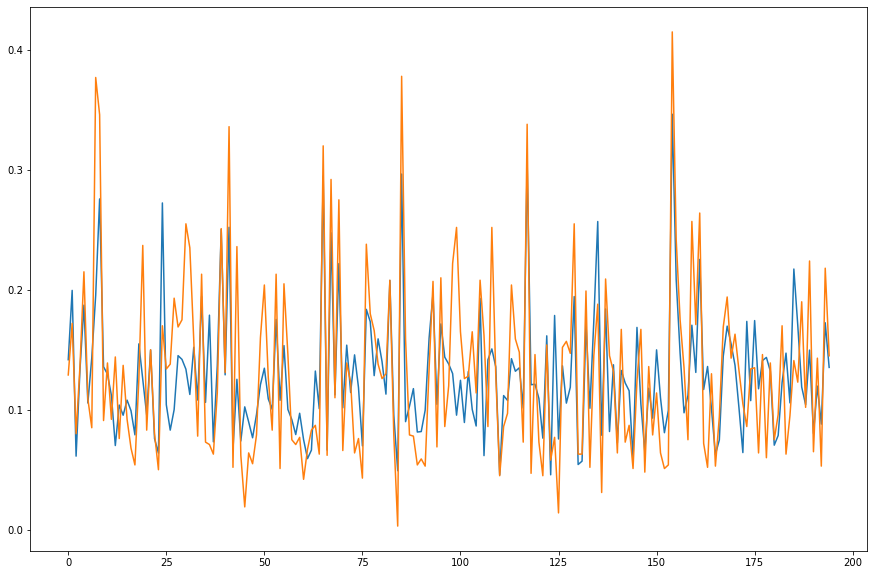

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(model.predict(X_test)[::5])
plt.plot(y_test.values[::5])
plt.show()

In [33]:
y_test.compare(pd.DataFrame(model.predict(X_test),index=y_test.index,columns=y_test.columns))

сыпуч известь РП          
                  self     other
index                           
5706             0.129  0.141729
6823             0.159  0.089300
3121             0.052  0.142320
827              0.149  0.091461
6472             0.186  0.152986
...                ...       ...
6826             0.143  0.122425
3119             0.089  0.102219
6494             0.145  0.135293
1248             0.066  0.074849
5465             0.168  0.114980

[973 rows x 2 columns]

In [32]:

y_test

,сыпуч известь РП
index,
5706,0.129
6823,0.159
3121,0.052
827,0.149
6472,0.186
...,...
6826,0.143
3119,0.089
6494,0.145
